In [ ]:
import time
import tracemalloc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class Node:
    def __init__(self, data, axis, split_point, lc, rc):
        self.data = data
        self.axis = axis
        self.lc = lc
        self.rc = rc
        self.split_point = split_point

class KDTree:
	def __init__(self, data, leaf_size=2):
		_data = np.concatenate([data, np.arange(data.shape[0]).reshape(-1, 1)], axis=1)
		self.data = _data
		self.leaf_size = leaf_size
		self.tree = self.build_tree(_data)
  
	def build_tree(self, data, depth=0):
		if data.shape[0] <= self.leaf_size:
			return Node(data, -1, None, None, None)
		else:
			axis = np.argmax(np.var(data, axis=0)[:-1]) # remove the index col
			data = data[data[:, axis].argsort()]
			median = data.shape[0] // 2
			return Node(data, axis, data[median], 
               			self.build_tree(data[:median], depth + 1), 
                  		self.build_tree(data[median:], depth + 1))
	
	def query(self, x, k=1):
		return self.query_dfs(self.tree, x, k)

	def query_dfs(self, node, q, k):
		if node is None:
			assert False
			return np.array([]), np.array([])
     
		if node.data.shape[0] <= k or node.axis == -1:
			res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                         			node.data[:, -1].reshape(-1, 1)], axis=1)
			res.sort(axis=0)
			return res[:k, 0], res[:k, 1]

		if q[node.axis] <= node.split_point[node.axis]:
			if node.lc.data.shape[0] < k:
				res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                          				node.data[:, -1].reshape(-1, 1)], axis=1)
				res.sort(axis=0)
				return res[:k, 0], res[:k, 1]
			else:
				return self.query_dfs(node.lc, q, k)
		else:
			if node.rc.data.shape[0] < k:
				res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                          				node.data[:, -1].reshape(-1, 1)], axis=1)
				res.sort(axis=0)
				return res[:k, 0], res[:k, 1]
			else:
				return self.query_dfs(node.rc, q, k)


In [3]:
def visualize_kdtree(tree, data, q, k, **kwargs):
	plt.figure(figsize=(7, 7))
	plt.title('KDTree Visualisation')
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.xlim(0, 100)
	plt.ylim(0, 100)
	plt.grid(True)
	plt.scatter(data[:, 0], data[:, 1], label='Data points')
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')
	dist, idx = tree.query(q, k)
	plt.scatter(data[idx.astype(int), 0], 
				data[idx.astype(int), 1], c='g', label='Nearest points')
	visualize_kdtree_dfs(tree.tree, **kwargs)
	plt.legend()

def visualize_kdtree_dfs(tree, range_x=[0, 100], range_y=[0, 100], depth=0, a=0.4):
	if tree is None:
		return

	range_x_lc = range_x
	range_x_rc = range_x
	range_y_lc = range_y
	range_y_rc = range_y

	if tree.axis == 0:
		plt.plot([tree.split_point[0], tree.split_point[0]], range_y, 'r-', alpha=(a)**depth, label='Split lines' if depth == 0 else "")
		range_x_lc = [range_x[0], tree.split_point[0]]
		range_x_rc = [tree.split_point[0], range_x[1]]
	elif tree.axis == 1:
		plt.plot(range_x, [tree.split_point[1], tree.split_point[1]], 'r-', alpha=(a)**depth, label='Split lines' if depth == 0 else "")
		range_y_lc = [range_y[0], tree.split_point[1]]
		range_y_rc = [tree.split_point[1], range_y[1]]
  
	visualize_kdtree_dfs(tree.lc, range_x_lc, range_y_lc, depth=depth+1, a=a)
	visualize_kdtree_dfs(tree.rc, range_x_rc, range_y_rc, depth=depth+1, a=a)

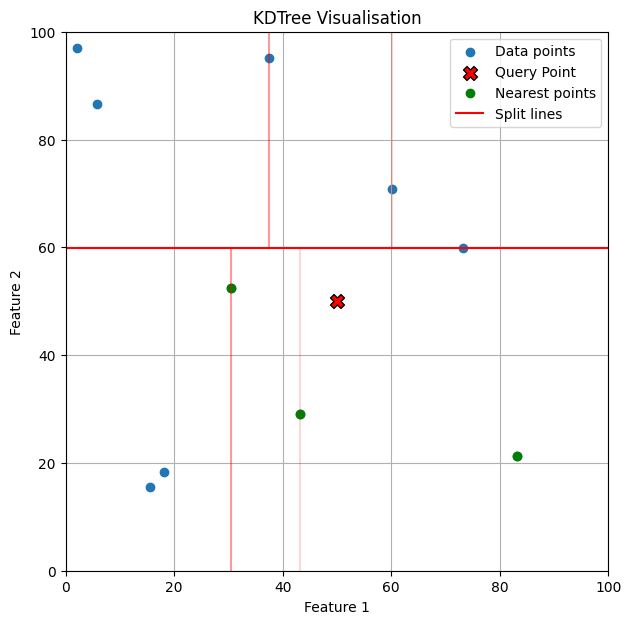

In [4]:
np.random.seed(42)
data = np.random.rand(10, 2) * 100
kdtree = KDTree(data, leaf_size=2) 
visualize_kdtree(kdtree, data, np.array([50, 50]), 3)

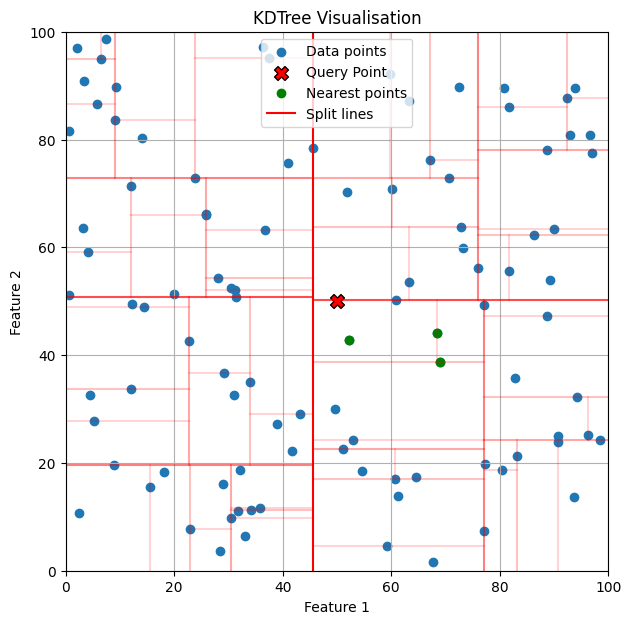

In [5]:
np.random.seed(42)
data = np.random.rand(100, 2) * 100
kdtree = KDTree(data, leaf_size=2)
q = np.array([50, 50])
k = 3
visualize_kdtree(kdtree, data, q, k, a=0.7)

In [6]:
class LSH:
	def __init__(self, data, num_proj=10):
		self.data = np.concatenate([np.ones(data.shape[0]).reshape(-1, 1), data], axis=1)
		self.num_proj = num_proj
		self.proj = np.random.rand(num_proj, self.data.shape[1]) * 2 - 1
		self.hashes = self.get_hash(self.data)
		self.clusters = {}

		for i in range(self.data.shape[0]):
			hash = self.hashes[i].tobytes()
			if hash not in self.clusters:
				self.clusters[hash] = []
			self.clusters[hash].append(np.concatenate([self.data[i], [i]]))

		for key, val in self.clusters.items():
			self.clusters[key] = np.array(val)
  
	def get_hash(self, data):
		hash = []
		for i in range(self.num_proj):
			proj = self.proj[i]
			proj_data = np.dot(data, proj)
			hash.append(proj_data > 0)
		return np.array(hash).T
	
	def query(self, x, k=1):
		hash = self.get_hash(np.concatenate([np.ones(1).reshape(-1, 1), x.reshape(1, -1)], axis=1))[0]

		if hash.tobytes() in self.clusters:
			cluster = np.array(self.clusters[hash.tobytes()])
			dist = np.linalg.norm(cluster[:, 1:-1] - x, axis=1)
			idx = np.argsort(dist)
			return dist[idx[:min(k, len(dist))]], cluster[idx[:min(k, len(dist))], -1]

In [7]:
def visualize_kdtree(model, data, q, k):
	plt.figure(figsize=(7, 7))
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')

	colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
	for i, (_, vec) in enumerate(model.clusters.items()):
		color = colours[i % len(colours)]
		plt.scatter(vec[:, 1], vec[:, 2], color=color, alpha=0.6, edgecolor='k')
	
	dist, idx = model.query(q, k)
	plt.scatter(data[idx.astype(int), 0], data[idx.astype(int), 1], color='blue', label=f'{k} Nearest Neighbors', edgecolor='k', s=100)
	for i in range(model.num_proj):
		plt.plot([0, 1], [-model.proj[i][0] / model.proj[i][2], -(model.proj[i][1] + model.proj[i][0]) / model.proj[i][2]], 'r--', linewidth=1.5, label=f'Projection Line' if i == 0 else "")


	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('LSH with Nearest Neighbors and Projection Lines')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.show()

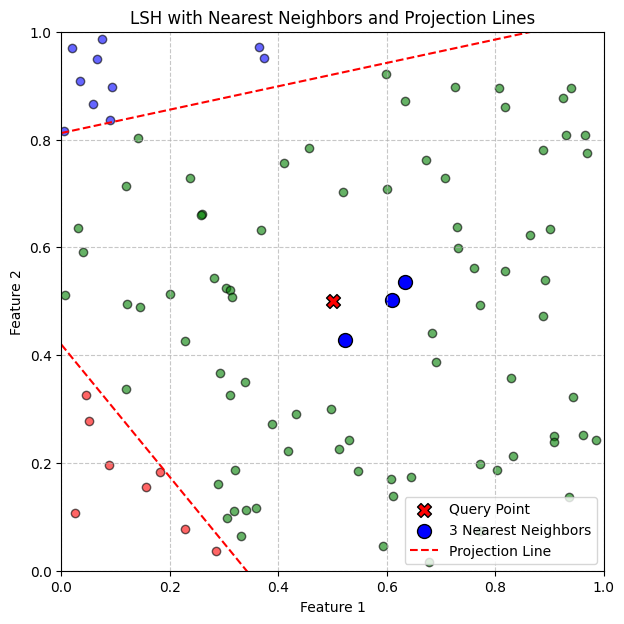

In [8]:
np.random.seed(42)
data = np.random.rand(100, 2)
lsh = LSH(data, num_proj=2)
visualize_kdtree(lsh, data, np.array([0.5, 0.5]), 3)

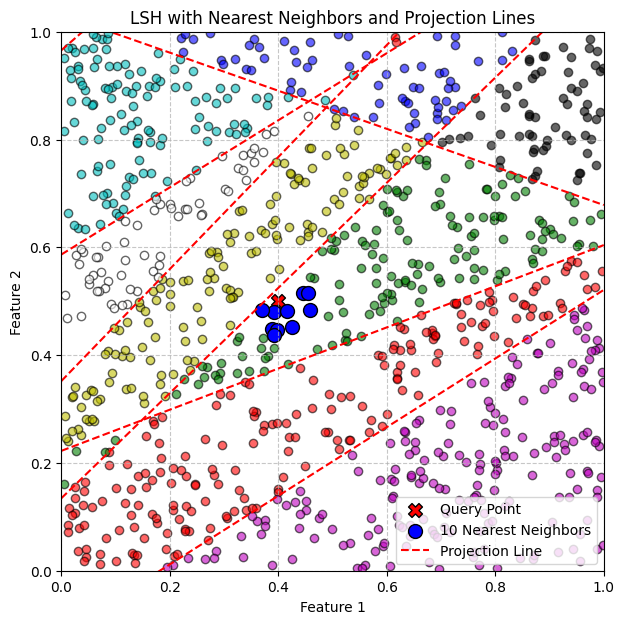

In [9]:
np.random.seed(42)
data = np.random.rand(1000, 2)
lsh = LSH(data, num_proj=10)
visualize_kdtree(lsh, data, np.array([0.4, 0.5]), 10)

In [10]:
class KNN:
	def __init__(self, data):
		self.data = data
	
	def query(self, x, k=1):
		distances = np.linalg.norm(self.data - x, axis=1)
		idx = np.argsort(distances)[:k]
		distances.sort()
		return distances[:k], idx

In [11]:
def visualize_knn(model, data, q, k):
	plt.figure(figsize=(7, 7))
	plt.scatter(data[:, 0], data[:, 1], label='Data points')
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')
	
	dist, idx = model.query(q, k)
	plt.scatter(data[idx, 0], data[idx, 1], color='blue', label=f'{k} Nearest Neighbors', edgecolor='k', s=100)

	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('KNN with Nearest Neighbors')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.show()

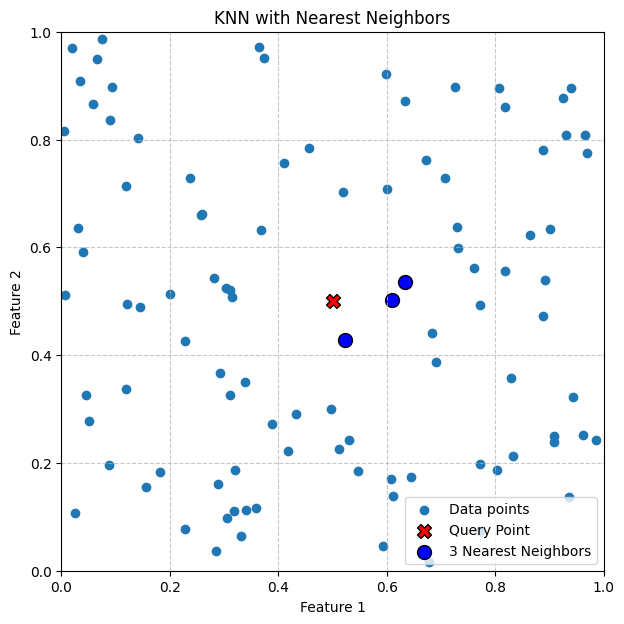

In [12]:
np.random.seed(42)
data = np.random.rand(100, 2)
knn = KNN(data)
visualize_knn(knn, data, np.array([0.5, 0.5]), 3)

In [ ]:
np.random.seed(42)

# Define hyperparameters
N_vals = [10, 100, 1000, 10000, 100000]
D_vals = [2, 5, 10, 100, 500, 1000]
K_vals = [1, 3, 5, 10, 15, 20]
models = [KNN, LSH, KDTree]
iter = 10

# Initialize DataFrame to store results
performance = pd.DataFrame(columns=['Model', 'N', 'D', 'K', 'Training Time', 'Testing Time', 'Training Memory', 'Testing Memory'])
loader = tqdm(total=len(N_vals) * len(D_vals) * len(K_vals) * len(models) * iter)

for N in N_vals:
    for D in D_vals:
        for K in K_vals:
            training_times = {}
            testing_times = {}
            training_memories = {}
            testing_memories = {}
            for _ in range(iter):
                data = np.random.rand(N, D)
                q = np.random.rand(D)
                for model_cls in models:
                    loader.update(1)

                    # Track memory and time for training
                    tracemalloc.start()
                    training_start = time.process_time()
                    if model_cls == LSH:
                        model = model_cls(data, num_proj=10)
                    else:
                        model = model_cls(data)
                    training_end = time.process_time()
                    training_memory = tracemalloc.get_traced_memory()[1]  # Peak memory usage
                    tracemalloc.stop()

                    # Track memory and time for testing
                    tracemalloc.start()
                    testing_start = time.process_time()
                    model.query(q, K)
                    testing_end = time.process_time()
                    testing_memory = tracemalloc.get_traced_memory()[1]  # Peak memory usage
                    tracemalloc.stop()

                    # Record results
                    if model_cls not in training_times:
                        training_times[model_cls] = []
                        testing_times[model_cls] = []
                        training_memories[model_cls] = []
                        testing_memories[model_cls] = []
                    training_times[model_cls].append(training_end - training_start)
                    testing_times[model_cls].append(testing_end - testing_start)
                    training_memories[model_cls].append(training_memory)
                    testing_memories[model_cls].append(testing_memory)

            # Aggregate results and append to DataFrame
            for model_cls in models:
                performance = performance._append({
                    'Model': model_cls.__name__,
                    'N': N,
                    'D': D,
                    'K': K,
                    'Training Time': np.mean(training_times[model_cls]),
                    'Testing Time': np.mean(testing_times[model_cls]),
                    'Training Memory': np.mean(training_memories[model_cls]),
                    'Testing Memory': np.mean(testing_memories[model_cls])
                }, ignore_index=True)

loader.close()

 51%|█████▏    | 1845/3600 [00:13<00:12, 137.54it/s]
C:\Users\DELL\AppData\Local\Temp\ipykernel_1752\2147656691.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = performance._append({
100%|██████████| 3600/3600 [07:20<00:00,  8.17it/s] 


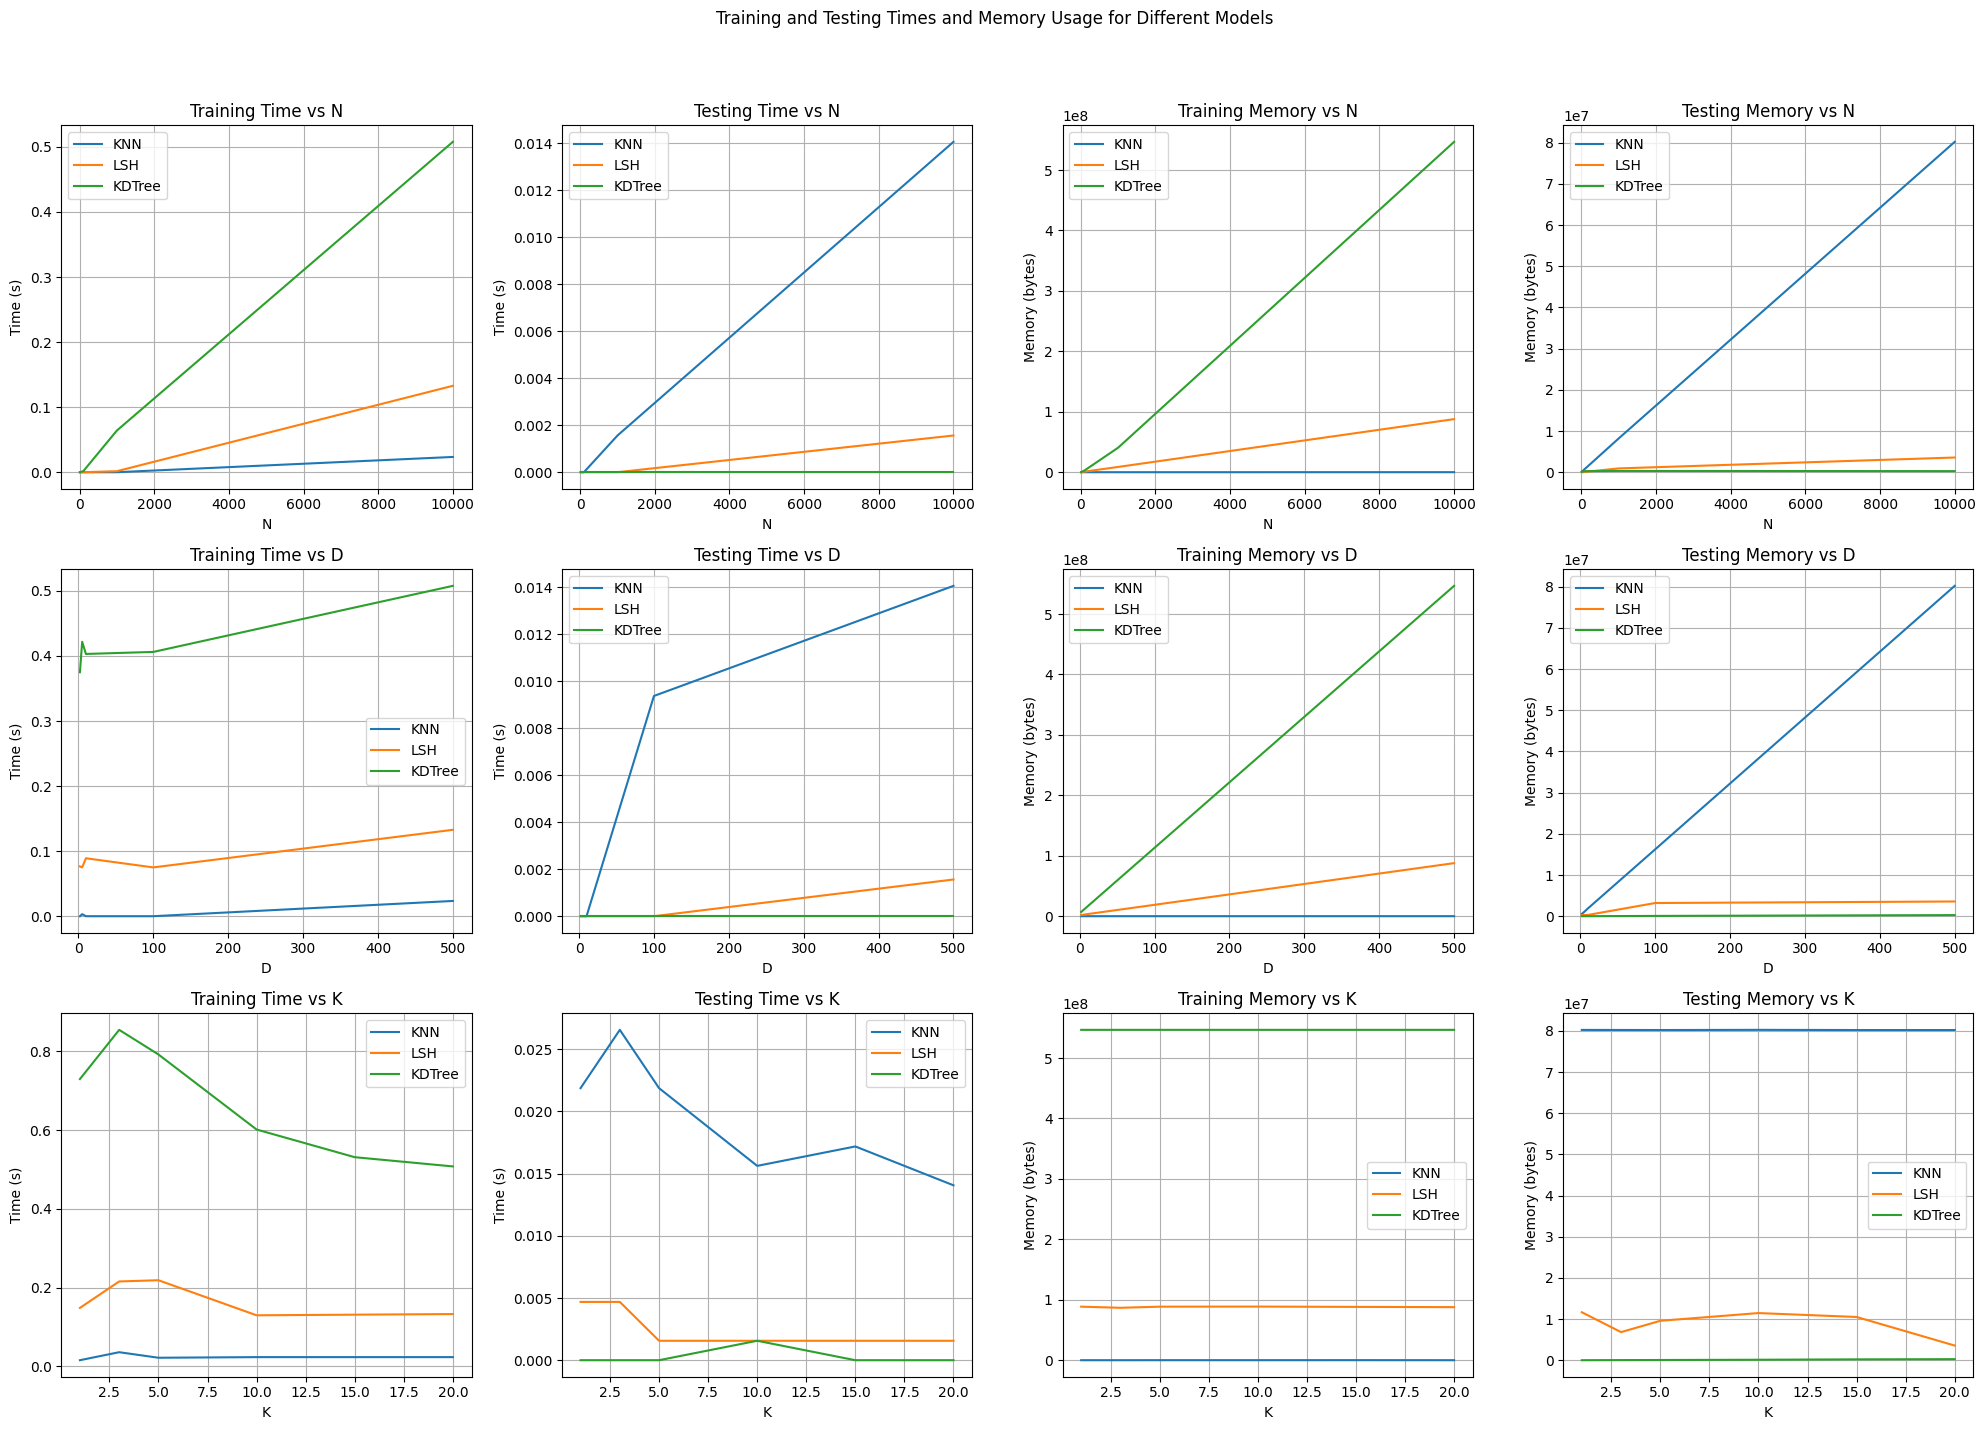

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Training and Testing Times and Memory Usage for Different Models')

for i, (var, var_name) in enumerate(zip([N_vals, D_vals, K_vals], ['N', 'D', 'K'])):
    for model_cls, model_name in zip(models, ['KNN', 'LSH', 'KDTree']):
        model_times = performance[performance['Model'] == model_name]
        if var_name != 'K':
            model_times = model_times[model_times['K'] == max(K_vals)]
        if var_name != 'D':
            model_times = model_times[model_times['D'] == max(D_vals)]
        if var_name != 'N':
            model_times = model_times[model_times['N'] == max(N_vals)]
        
        # Plot Training Time
        axs[i, 0].plot(var, model_times['Training Time'], label=model_name)
        axs[i, 0].set_title(f'Training Time vs {var_name}')
        axs[i, 0].set_xlabel(var_name)
        axs[i, 0].set_ylabel('Time (s)')
        axs[i, 0].grid(True)
        axs[i, 0].legend()
  
        # Plot Testing Time
        axs[i, 1].plot(var, model_times['Testing Time'], label=model_name)
        axs[i, 1].set_title(f'Testing Time vs {var_name}')
        axs[i, 1].set_xlabel(var_name)
        axs[i, 1].set_ylabel('Time (s)')
        axs[i, 1].grid(True)
        axs[i, 1].legend()

        # Plot Training Memory
        axs[i, 2].plot(var, model_times['Training Memory'], label=model_name)
        axs[i, 2].set_title(f'Training Memory vs {var_name}')
        axs[i, 2].set_xlabel(var_name)
        axs[i, 2].set_ylabel('Memory (bytes)')
        axs[i, 2].grid(True)
        axs[i, 2].legend()

        # Plot Testing Memory
        axs[i, 3].plot(var, model_times['Testing Memory'], label=model_name)
        axs[i, 3].set_title(f'Testing Memory vs {var_name}')
        axs[i, 3].set_xlabel(var_name)
        axs[i, 3].set_ylabel('Memory (bytes)')
        axs[i, 3].grid(True)
        axs[i, 3].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()